In [2]:
import os
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [3]:
FILEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/interim'
LANDTHRESH = 0.5

In [4]:
variables = {
    'pr':{
        'data':xr.open_dataarray(f'{FILEDIR}/pr.nc',engine='h5netcdf'),
        'label':'Precipitation Rate (mm/hr)',
        'is_4D':False,
        'analyze':False},
    'lf':{
        'data':xr.open_dataarray(f'{FILEDIR}/lf.nc',engine='h5netcdf'),
        'label':'Land Fraction (0-1)',
        'is_4D':False,
        'analyze':False},
    'bl':{
        'data':xr.open_dataarray(f'{FILEDIR}/bl.nc',engine='h5netcdf'),
        'label':'$\mathit{B_L}$ (m/s$^2$)',
        'is_4D':False,
        'analyze':True},
    'cape':{
        'data':xr.open_dataarray(f'{FILEDIR}/cape.nc',engine='h5netcdf'),
        'label':'$CAPE_L$ (K)',
        'is_4D':False,
        'analyze':True},
    'subsat':{
        'data':xr.open_dataarray(f'{FILEDIR}/subsat.nc',engine='h5netcdf'),
        'label':'$SUBSAT_L$ (K)',
        'is_4D':False,
        'analyze':True},
    'capeproxy':{
        'data':xr.open_dataarray(f'{FILEDIR}/capeproxy.nc',engine='h5netcdf'),
        'label':r'$\theta_{e}$(surface) - $\theta_{e}$* (K)',
        'is_4D':True,
        'analyze':True},
    'subsatproxy':{
        'data':xr.open_dataarray(f'{FILEDIR}/subsatproxy.nc',engine='h5netcdf'),
        'label':r'$\theta_{e}$* - $\theta_{e}$ (K)',
        'is_4D':True,
        'analyze':True},
    't':{
        'data':xr.open_dataarray(f'{FILEDIR}/t.nc',engine='h5netcdf'),
        'label':'Temperature (K)',
        'is_4D':True,
        'analyze':True},
    'q':{
        'data':xr.open_dataarray(f'{FILEDIR}/q.nc',engine='h5netcdf'),
        'label':'Specific Humidity (kg/kg)',
        'is_4D':True,
        'analyze':True}}

In [5]:
prvalues = variables['pr']['data'].load().values
lfvalues = variables['lf']['data'].load().values

In [6]:
landmask = (lfvalues>=LANDTHRESH)
if landmask.ndim==2:
    landmask = np.broadcast_to(landmask[np.newaxis,:,:],prvalues.shape)
oceanmask = ~landmask

In [7]:
def _fast_corrcoef(x,y):
    xmean = x.mean()
    ymean = y.mean()
    xc = x-xmean
    yc = y-ymean
    return (xc*yc).sum()/np.sqrt((xc**2).sum()*(yc**2).sum())

def _calc_single_correlation(x,y,landmask,oceanmask,nsamples=None,seed=42):
    rng = np.random.default_rng(seed)
    xflat = x.ravel()
    yflat = y.ravel()
    landflat  = landmask.ravel()
    oceanflat = oceanmask.ravel()
    finite = ~(np.isnan(xflat)|np.isnan(yflat))
    xfinite = xflat[finite]
    yfinite = yflat[finite]
    landfinite  = landflat[finite]
    oceanfinite = oceanflat[finite]
    if nsamples and len(xfinite)>nsamples:
        idxs = rng.choice(len(xfinite),size=nsamples,replace=False)
        xfinite = xfinite[idxs]
        yfinite = yfinite[idxs]
        landfinite  = landfinite[idxs]
        oceanfinite = oceanfinite[idxs]
    corrall   = _fast_corrcoef(xfinite,yfinite)
    corrland  = _fast_corrcoef(xfinite[landfinite],yfinite[landfinite])
    corrocean = _fast_corrcoef(xfinite[oceanfinite],yfinite[oceanfinite])
    return {'all':corrall,'land':corrland,'ocean':corrocean}

def calc_correlation(xvalues,yvalues,landmask,oceanmask,nsamples=None):
    if xvalues.ndim==4:
        nlevs = xvalues.shape[-1]
        corrall   = np.zeros(nlevs)
        corrland  = np.zeros(nlevs)
        corrocean = np.zeros(nlevs)
        for levidx in range(nlevs):
            xlev = xvalues[:,:,:,levidx]  
            corr = _calc_single_correlation(xlev,yvalues,landmask,oceanmask,nsamples,42+levidx)
            corrall[levidx]   = corr['all']
            corrland[levidx]  = corr['land']
            corrocean[levidx] = corr['ocean']
        return {'all': corrall,'land':corrland,'ocean':corrocean}
    else:
        return _calc_single_correlation(xvalues,yvalues,landmask,oceanmask,nsamples,42)

In [8]:
results = {}
for varname,varinfo in variables.items():
    if not varinfo['analyze']:
        continue
    is_4D = varinfo['is_4D']
    nsamples = 10000 if is_4D else 20000
    xvalues = varinfo['data'].load().values
    corr = calc_correlation(xvalues,prvalues,landmask,oceanmask,nsamples)
    results[varname] = corr

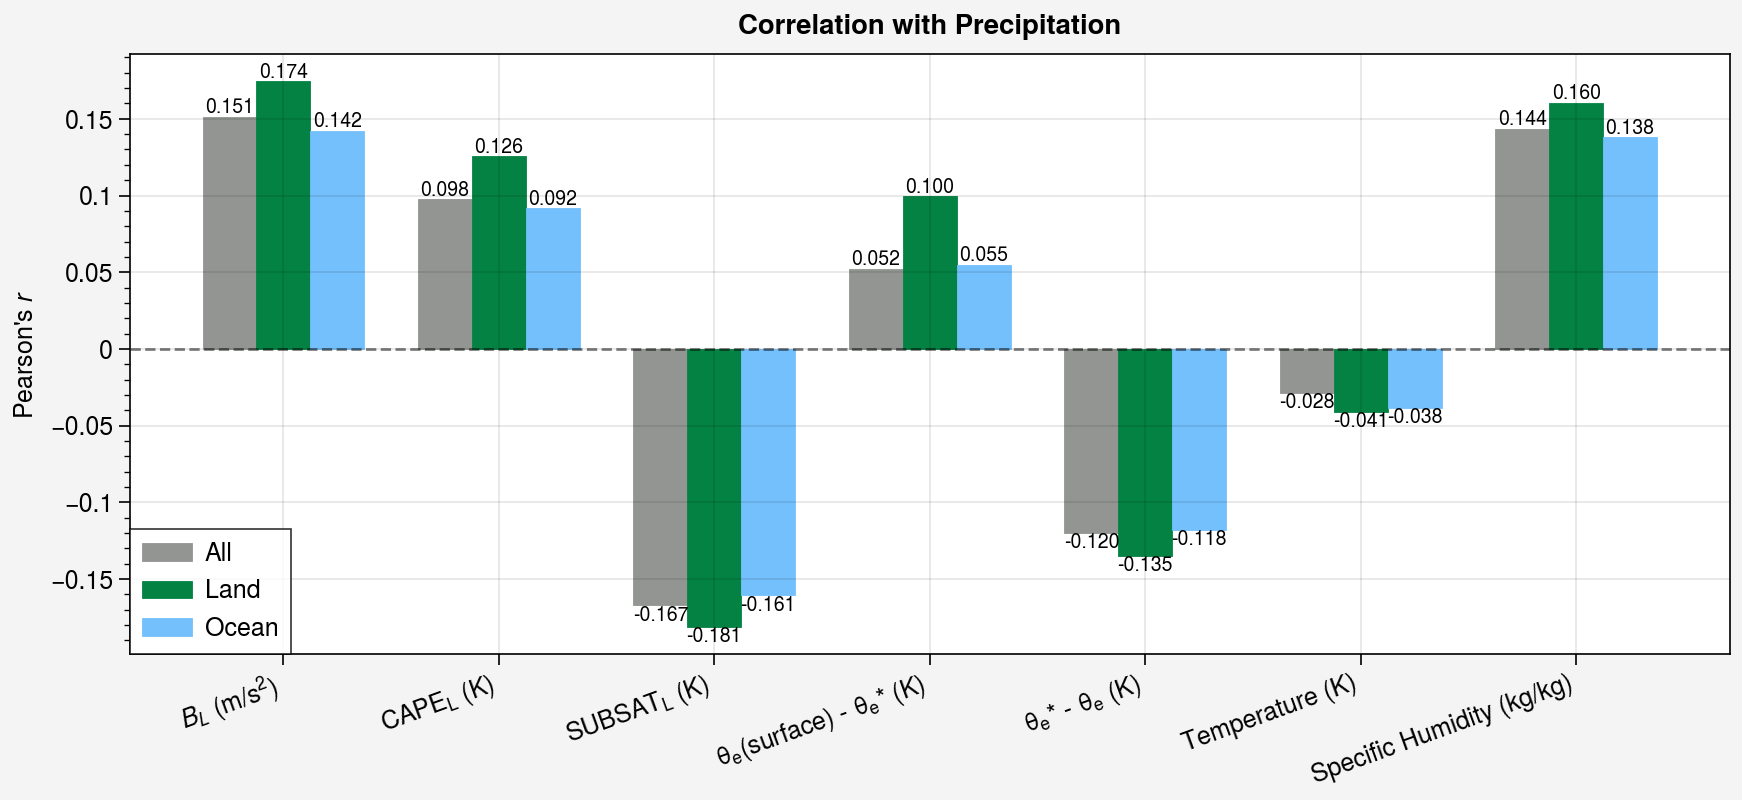

In [9]:
summarydata  = []
varnameslist = []
for varname,corr in results.items():
    is_4D = variables[varname]['is_4D']
    if is_4D:
        allcorr   = np.nanmean(corr['all'])
        landcorr  = np.nanmean(corr['land'])
        oceancorr = np.nanmean(corr['ocean'])
    else:
        allcorr   = corr['all']
        landcorr  = corr['land']
        oceancorr = corr['ocean']
    summarydata.append([allcorr,landcorr,oceancorr])
    varnameslist.append(variables[varname]['label'])
summaryarr = np.array(summarydata)

fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=8,refheight=3)
x,width = np.arange(len(varnameslist)),0.25
ax.format(suptitle='Correlation with Precipitation',xlocator=x,xformatter=varnameslist,xrotation=20,
          xminorticks='none',ylabel="Pearson's $\mathit{r}$")
bars1 = ax.bar(x-width,summaryarr[:,0],width,label='All',color='gray')
bars2 = ax.bar(x,summaryarr[:,1],width,label='Land',color='jungle green')
bars3 = ax.bar(x+width,summaryarr[:,2],width,label='Ocean',color='blue3')
for i,(allvalue,landvalue,oceanvalue) in enumerate(summaryarr):
    ax.text(i-width,allvalue,f'{allvalue:.3f}',ha='center',va='bottom' if allvalue>0 else 'top',fontsize=7)
    ax.text(i,landvalue,f'{landvalue:.3f}',ha='center',va='bottom' if landvalue>0 else 'top',fontsize=7)
    ax.text(i+width, oceanvalue, f'{oceanvalue:.3f}',ha='center',va='bottom' if oceanvalue>0 else 'top',fontsize=7)
ax.axhline(0,color='k',alpha=0.5,linewidth=1,linestyle='--')
ax.legend(loc='ll',ncols=1)
pplt.show()

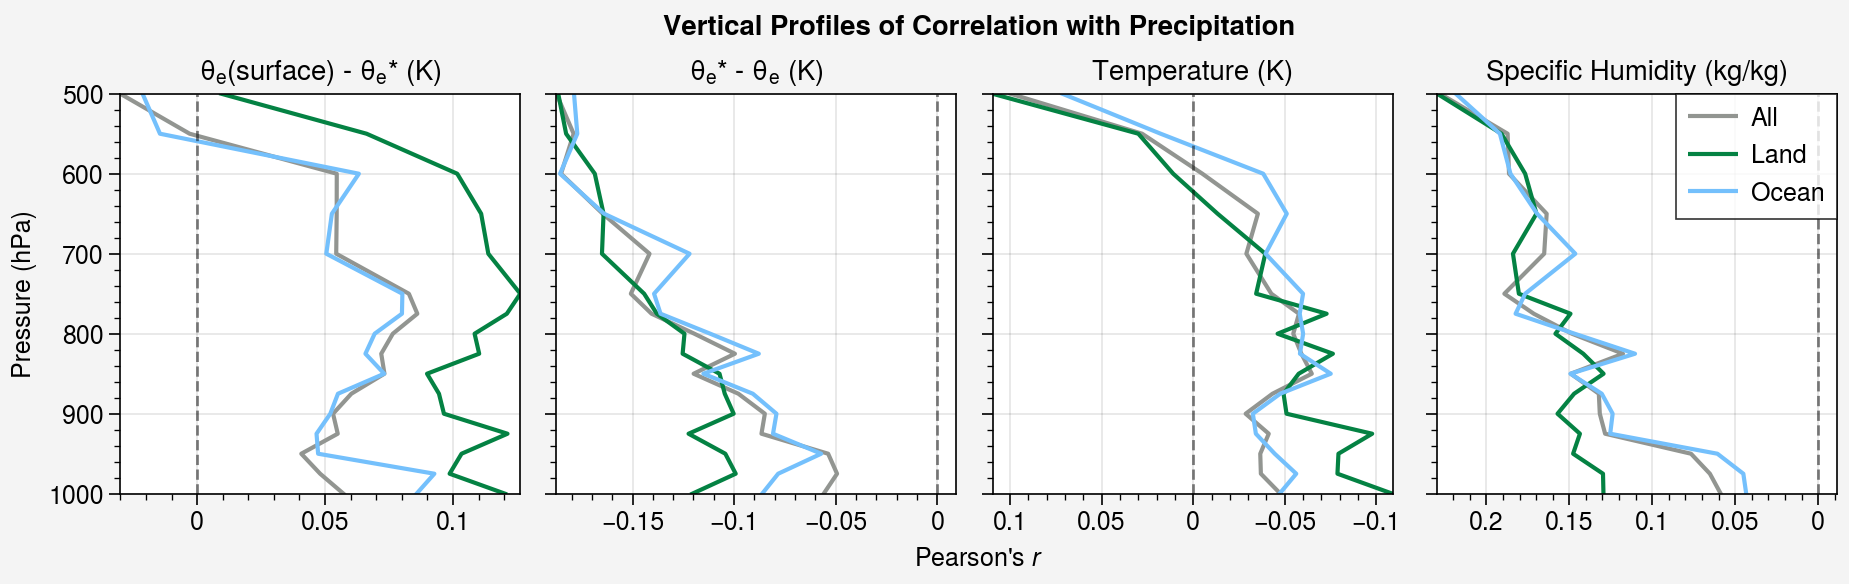

In [10]:
vars4D = [(varname,varinfo) for varname,varinfo in variables.items() if varinfo.get('analyze',False) and varinfo['is_4D']]

fig,axs = pplt.subplots(ncols=len(vars4D),refwidth=2,share=True)
axs.format(suptitle='Vertical Profiles of Correlation with Precipitation',
           xlabel="Pearson's $\mathit{r}$",ylabel='Pressure (hPa)',yreverse=True,ylim=(1000,500))
for i,(varname,varinfo) in enumerate(vars4D):
    corr = results[varname]
    levs = varinfo['data']['lev'].values 
    axs[i].plot(corr['all'],levs,label='All',color='gray',linewidth=1.5)
    axs[i].plot(corr['land'],levs,label='Land',color='jungle green',linewidth=1.5)
    axs[i].plot(corr['ocean'],levs,label='Ocean',color='blue3',linewidth=1.5)
    axs[i].format(title=varinfo['label'])
    axs[i].axvline(0,color='k',linewidth=1,linestyle='--',alpha=0.5)
axs[3].legend(loc='ur',ncols=1)
pplt.show()